In [1]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("nasdaq100_padding.csv")


In [2]:
data

,AAL,AAPL,ADBE,ADI,ADP,ADSK,AKAM,ALXN,AMAT,AMGN,...,TXN,VIAB,VOD,VRTX,WBA,WDC,WFM,XLNX,YHOO,NDX
0,35.9800,96.800,97.80,61.1500,95.4000,58.180000,58.00,127.0400,26.6800,165.8100,...,70.7300,45.2300,31.1701,95.2700,81.365,52.160,33.95,48.6100,38.0100,4665.054
1,35.9310,96.890,97.80,61.6100,95.4115,58.190000,58.12,126.0600,26.7300,165.9101,...,70.6900,45.0100,31.1900,94.1700,81.540,52.150,34.10,48.7400,38.1400,4665.054
2,35.9044,96.950,97.57,61.9800,95.5100,58.203333,57.95,126.5100,26.7120,166.1800,...,71.3000,45.0150,31.2100,94.7490,81.530,52.270,34.01,48.9900,38.1500,4665.826
3,35.8900,96.970,97.55,62.0900,95.5200,58.216667,57.96,126.2800,26.7400,166.1480,...,71.3100,45.0200,31.2100,94.3100,81.710,52.300,33.96,48.9500,38.1950,4667.081
4,36.0080,96.960,97.73,61.8900,95.5300,58.230000,58.21,126.5850,26.7200,165.9900,...,71.0600,45.0500,31.1800,94.1550,81.720,52.300,34.17,48.8900,38.3200,4664.491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40555,48.5030,115.880,104.19,73.2895,102.2900,74.690000,67.39,121.1264,32.9200,146.3911,...,73.8100,34.8100,24.7550,72.1400,84.330,70.230,32.04,59.9200,38.5300,4921.811
40556,48.5150,115.875,104.18,73.2900,102.3100,74.675000,67.43,121.2000,32.9300,146.3951,...,73.8100,34.7950,24.7597,72.0928,84.340,70.220,32.03,59.9290,38.5100,4921.580
40557,48.5300,115.875,104.15,73.2850,102.3200,74.680000,67.40,121.3500,32.9064,146.3700,...,73.8001,34.7901,24.7571,72.0600,84.350,70.165,32.03,59.9345,38.5084,4921.884
40558,48.5600,115.920,104.19,73.3000,102.3100,74.750000,67.35,121.3000,32.9200,146.3400,...,73.8101,34.8200,24.7500,72.0950,84.320,70.210,32.04,59.9400,38.5050,4922.949


In [3]:

batch_size = 128
timesteps = 20
n_timeseries = data.shape[1]
train_length = 35100
val_length = 2730
test_length = 2730
target = "NDX"

In [4]:
X = np.zeros((len(data), timesteps, data.shape[1]))


In [5]:
for i, name in enumerate(list(data.columns)):
    print(name)
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

AAL
AAPL
ADBE
ADI
ADP
ADSK
AKAM
ALXN
AMAT
AMGN
AMZN
ATVI
AVGO
BBBY
BIDU
BIIB
CA
CELG
CERN
CMCSA
COST
CSCO
CSX
CTRP
CTSH
DISCA
DISH
DLTR
EA
EBAY
ESRX
EXPE
FAST
FB
FOX
FOXA
GILD
GOOGL
INTC
JD
KHC
LBTYA
LBTYK
LRCX
MAR
MAT
MCHP
MDLZ
MSFT
MU
MXIM
MYL
NCLH
NFLX
NTAP
NVDA
NXPI
PAYX
PCAR
PYPL
QCOM
QVCA
ROST
SBUX
SIRI
STX
SWKS
SYMC
TMUS
TRIP
TSCO
TSLA
TXN
VIAB
VOD
VRTX
WBA
WDC
WFM
XLNX
YHOO
NDX


In [6]:
prediction_horizon = 1
target = data["NDX"].shift(-prediction_horizon).fillna(method="ffill").values

In [7]:

X = X[timesteps:]
target = target[timesteps:]

In [8]:

X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [9]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [10]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

In [11]:
target_val

array([0.36858817, 0.36997945, 0.37299836, ..., 1.15161218, 1.15192093,
       1.1478233 ])

In [12]:
X_train.shape

(35100, 20, 82)

In [13]:
trainX = np.reshape(X_train, (35100,1, 20, X_train.shape[2]))
valX = np.reshape(X_val, (2730,1, 20,X_val.shape[2]))
testX = np.reshape(X_test, (2730,1,20, X_test.shape[2] ))

In [70]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [20]:
look_back = 20
trainX, trainY = create_dataset_mul(X_train, look_back)
valX, valY = create_dataset_mul(X_val, look_back)
testX, testY = create_dataset_mul(X_test, look_back)

35080
2710
2710


In [71]:
trainX.shape

(35100, 1, 20, 82)

In [15]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,20,82))


in1=TimeDistributed(LSTM(150,return_sequences=True))(first_input)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/nasdaq_lstmconv1d_timedist_5_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, target_train, epochs=200, batch_size=100, validation_data=(valX, target_val), verbose=1, callbacks=[cb])

Train on 35100 samples, validate on 2730 samples
Epoch 1/200
17700/35100 [==============>...............] - ETA: 10s - loss: 0.0051WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 20, 82)]    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 20, 150)     139800    
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 16, 64)      48064     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 16, 64)      4160      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 8, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 512)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513 

In [17]:
model.load_weights("saved_weights/nasdaq_lstmconv1d_timedist_5_1.hdf5")

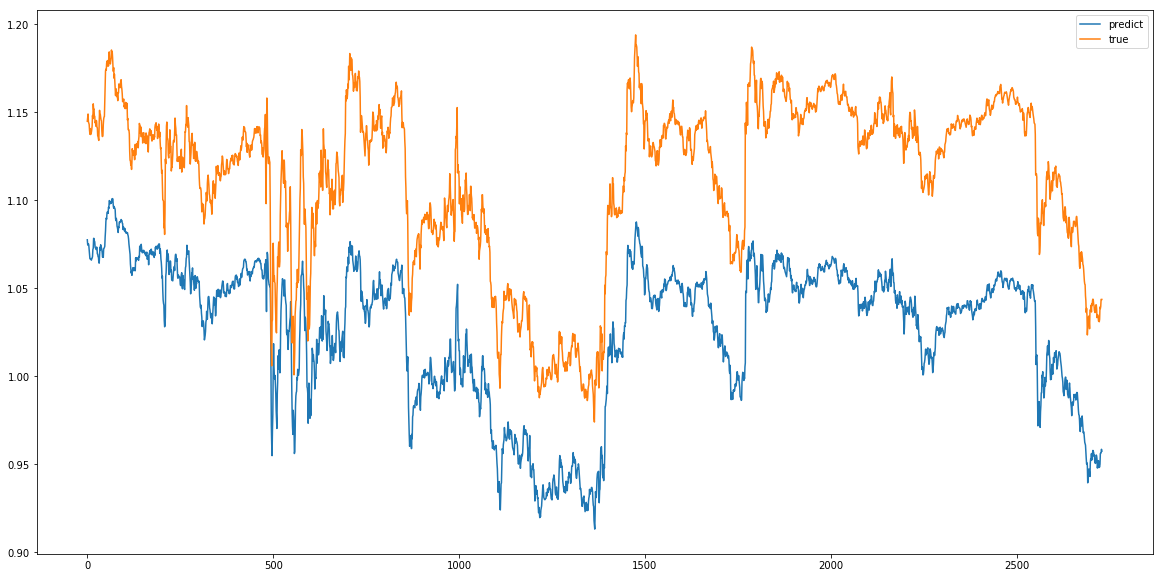

Test RMSE: 0.08752
Test MAE: 0.08620
Test MSE: 0.00766


In [18]:
# timelstm(150)_1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

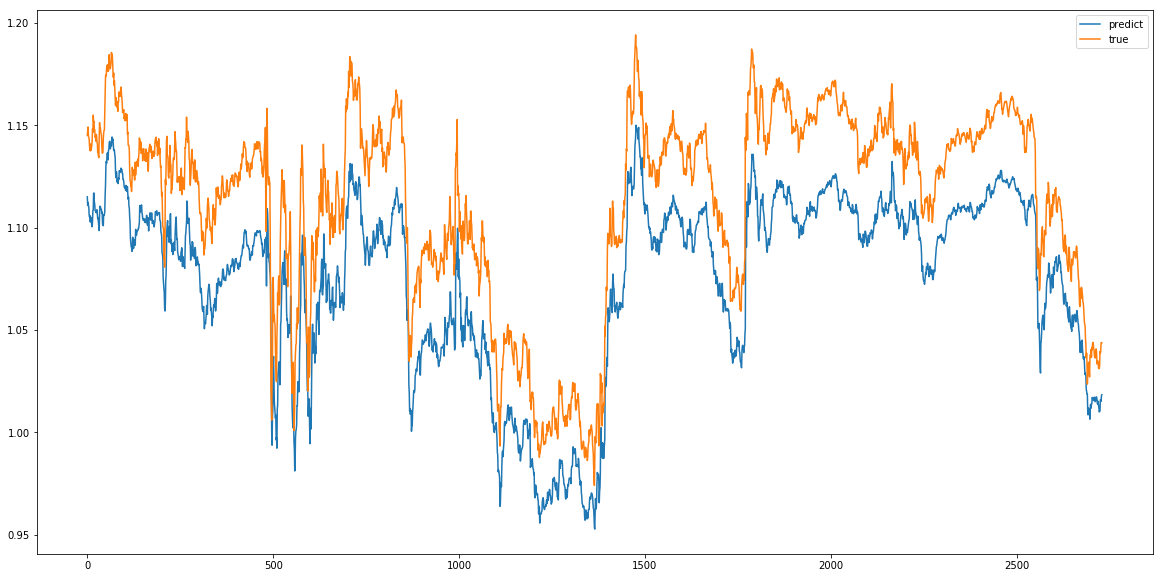

Test RMSE: 0.03874
Test MAE: 0.03778
Test MSE: 0.00150


In [49]:
# time1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

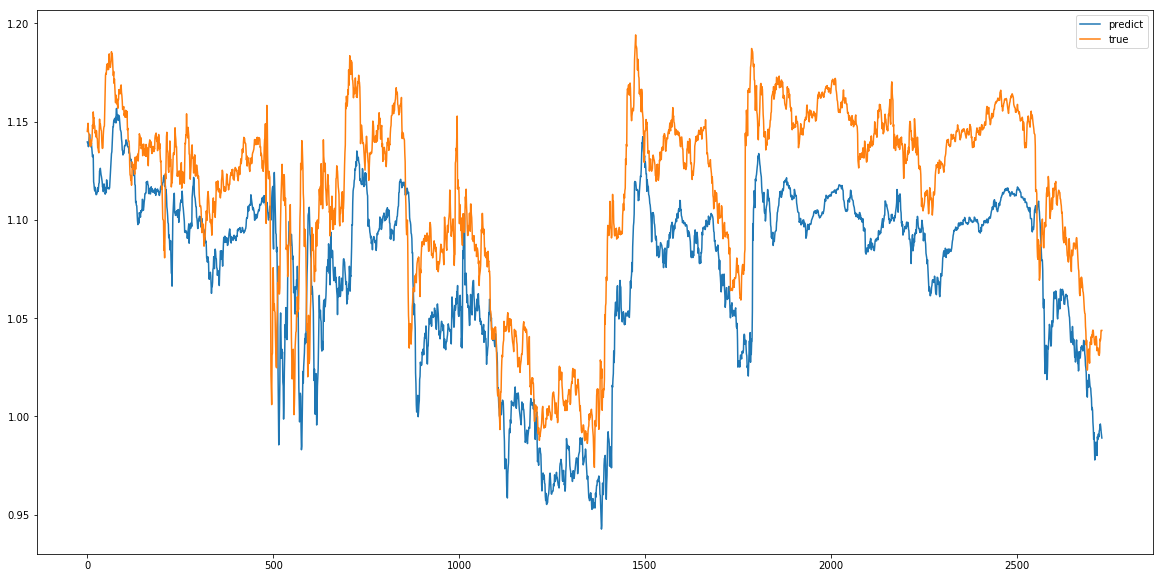

Test RMSE: 0.04704
Test MAE: 0.04172
Test MSE: 0.00221


NameError: name 'values' is not defined

In [35]:
# time1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=target_test*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


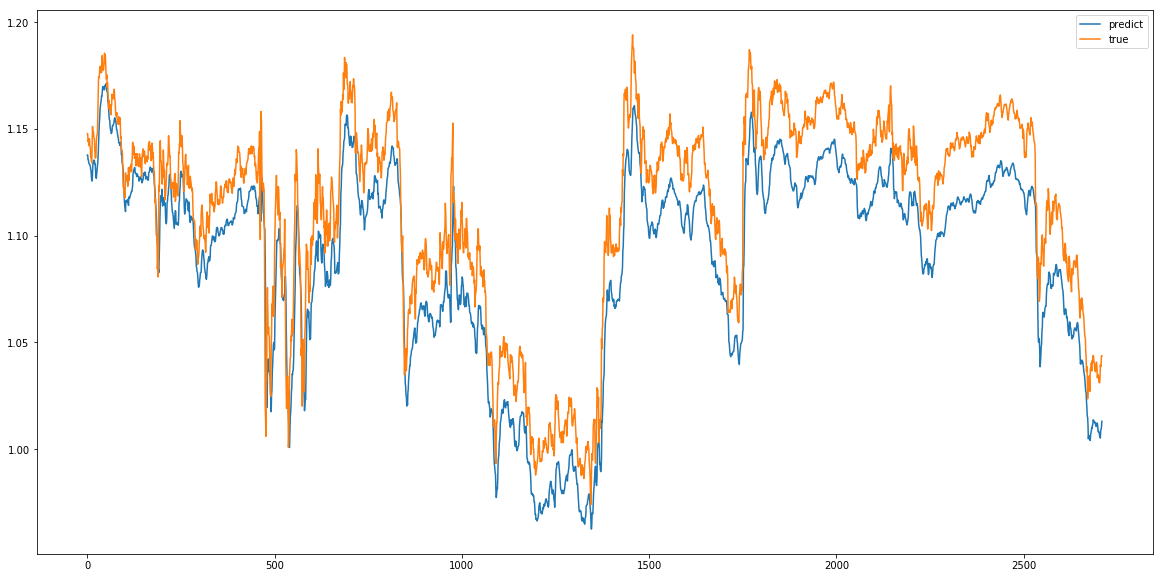

Test RMSE: 0.02475
Test MAE: 0.02317
Test MSE: 0.00061
Test RMSE: 122.71324
Test MAE: 114.88417


In [365]:
# time 1dcnn(5,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


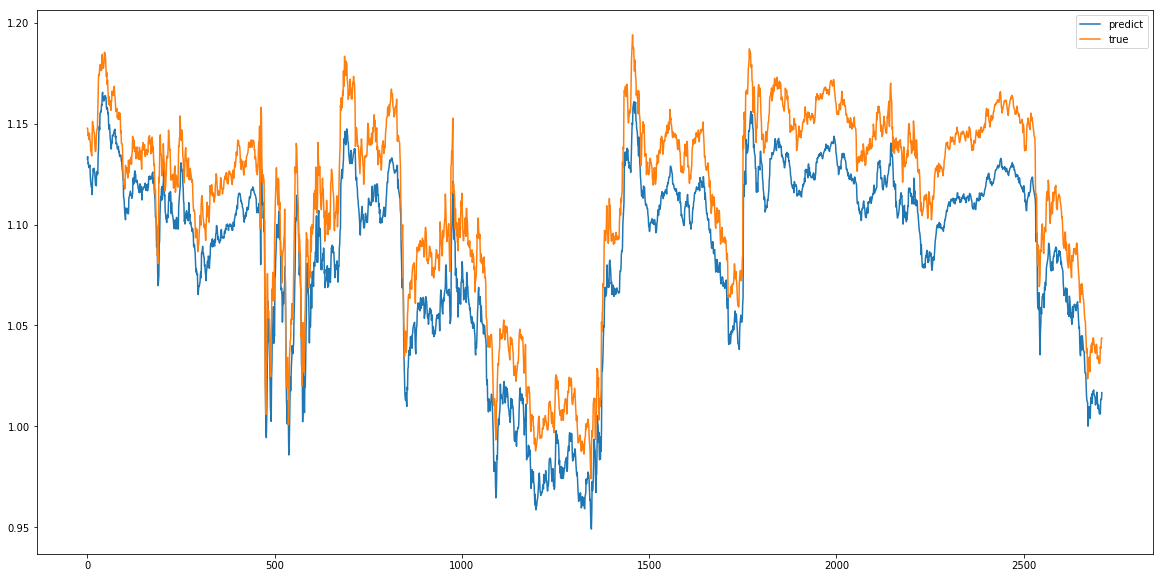

Test RMSE: 0.02759
Test MAE: 0.02662
Test MSE: 0.00076
Test RMSE: 136.80379
Test MAE: 131.97736


In [343]:
## time 1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [308]:
first_input = Input(shape=(20,82))

in1=Bidirectional(LSTM(150))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "saved_weights/nasdaq_timebilstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(X_train, target_train,validation_data=[X_val,target_val], epochs=200, verbose=1,callbacks=[cb])

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 20, 82)]          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 300)               279600    
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
_________________________________________________________________
Train on 35100 samples, validate on 2730 samples
Epoch 1/200
35040/35100 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00001: val_loss improved from inf to 0.00743, saving model to saved_weights/nasdaq_timebilstm.hdf5
35100/35100 [==============================] - 15s 438us/sample - loss: 0.0029 - val_loss: 0.0074
Epoch 2/200
35072/35100 [=======================

Epoch 30/200
35072/35100 [============================>.] - ETA: 0s - loss: 5.8970e-05
Epoch 00030: val_loss did not improve from 0.00044
35100/35100 [==============================] - 13s 381us/sample - loss: 5.8961e-05 - val_loss: 0.0010
Epoch 31/200
35072/35100 [============================>.] - ETA: 0s - loss: 6.3426e-05
Epoch 00031: val_loss did not improve from 0.00044
35100/35100 [==============================] - 13s 381us/sample - loss: 6.3409e-05 - val_loss: 0.0012
Epoch 32/200
35072/35100 [============================>.] - ETA: 0s - loss: 6.2058e-05
Epoch 00032: val_loss did not improve from 0.00044
35100/35100 [==============================] - 13s 381us/sample - loss: 6.2164e-05 - val_loss: 9.6778e-04
Epoch 33/200
35072/35100 [============================>.] - ETA: 0s - loss: 5.8557e-05
Epoch 00033: val_loss did not improve from 0.00044
35100/35100 [==============================] - 13s 381us/sample - loss: 5.8539e-05 - val_loss: 0.0014
Epoch 34/200
35072/35100 [==========

Epoch 64/200
34976/35100 [============================>.] - ETA: 0s - loss: 5.5547e-05
Epoch 00064: val_loss did not improve from 0.00040
35100/35100 [==============================] - 14s 388us/sample - loss: 5.5463e-05 - val_loss: 7.1251e-04
Epoch 65/200
35072/35100 [============================>.] - ETA: 0s - loss: 5.3263e-05
Epoch 00065: val_loss did not improve from 0.00040
35100/35100 [==============================] - 13s 381us/sample - loss: 5.3228e-05 - val_loss: 8.6067e-04
Epoch 66/200
35072/35100 [============================>.] - ETA: 0s - loss: 5.4302e-05
Epoch 00066: val_loss did not improve from 0.00040
35100/35100 [==============================] - 13s 381us/sample - loss: 5.4287e-05 - val_loss: 7.6295e-04
Epoch 67/200
35072/35100 [============================>.] - ETA: 0s - loss: 5.2571e-05
Epoch 00067: val_loss did not improve from 0.00040
35100/35100 [==============================] - 13s 381us/sample - loss: 5.2584e-05 - val_loss: 7.1453e-04
Epoch 68/200
35072/35100

Epoch 131/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.8530e-05
Epoch 00131: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.8522e-05 - val_loss: 7.4540e-04
Epoch 132/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.7601e-05
Epoch 00132: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.7587e-05 - val_loss: 6.5134e-04
Epoch 133/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.6358e-05
Epoch 00133: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.6339e-05 - val_loss: 5.9188e-04
Epoch 134/200
35040/35100 [============================>.] - ETA: 0s - loss: 4.6556e-05
Epoch 00134: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.6542e-05 - val_loss: 9.8698e-04
Epoch 135/200
35040/

Epoch 165/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.6106e-05
Epoch 00165: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.6081e-05 - val_loss: 5.5117e-04
Epoch 166/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.6891e-05
Epoch 00166: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 380us/sample - loss: 4.6876e-05 - val_loss: 6.7965e-04
Epoch 167/200
35008/35100 [============================>.] - ETA: 0s - loss: 4.5850e-05
Epoch 00167: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.5932e-05 - val_loss: 4.8832e-04
Epoch 168/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.6081e-05
Epoch 00168: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.6071e-05 - val_loss: 8.0118e-04
Epoch 169/200
35072/

Epoch 199/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.3654e-05
Epoch 00199: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 381us/sample - loss: 4.3640e-05 - val_loss: 7.9469e-04
Epoch 200/200
35072/35100 [============================>.] - ETA: 0s - loss: 4.3681e-05
Epoch 00200: val_loss did not improve from 0.00028
35100/35100 [==============================] - 13s 380us/sample - loss: 4.3670e-05 - val_loss: 8.5909e-04


In [76]:
model.load_weights('saved_weights/nasdaq_bilstm.hdf5')

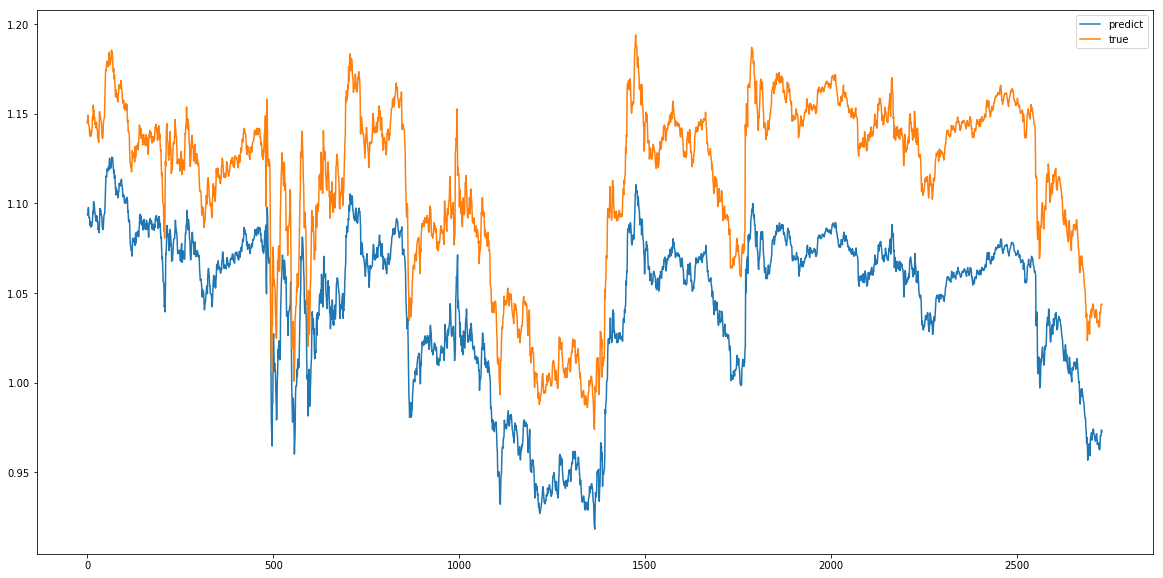

Test RMSE: 0.06935
Test MAE: 0.06823
Test MSE: 0.00481
Test RMSE: 343.85331
Test MAE: 338.28719


In [312]:
## bilstm(150)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([X_test])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=target_test*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [337]:
first_input = Input(shape=(20,82))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
in1= BatchNormalization(scale=False)(in1)

in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/nasdaq_1d_.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(X_train, target_train,validation_data=[X_val,target_val], epochs=200, verbose=1,callbacks=[cb])

Train on 35100 samples, validate on 2730 samples
Epoch 1/200
34912/35100 [============================>.] - ETA: 0s - loss: 0.0175
Epoch 00001: val_loss improved from inf to 0.01079, saving model to saved_weights/nasdaq_1d_.hdf5
35100/35100 [==============================] - 9s 243us/sample - loss: 0.0174 - val_loss: 0.0108
Epoch 2/200
34912/35100 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00002: val_loss improved from 0.01079 to 0.00695, saving model to saved_weights/nasdaq_1d_.hdf5
35100/35100 [==============================] - 6s 171us/sample - loss: 0.0018 - val_loss: 0.0070
Epoch 3/200
34976/35100 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00003: val_loss improved from 0.00695 to 0.00537, saving model to saved_weights/nasdaq_1d_.hdf5
35100/35100 [==============================] - 6s 166us/sample - loss: 0.0014 - val_loss: 0.0054
Epoch 4/200
34912/35100 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss improved

KeyboardInterrupt: 

In [338]:
model.load_weights("saved_weights/nasdaq_1d_.hdf5")

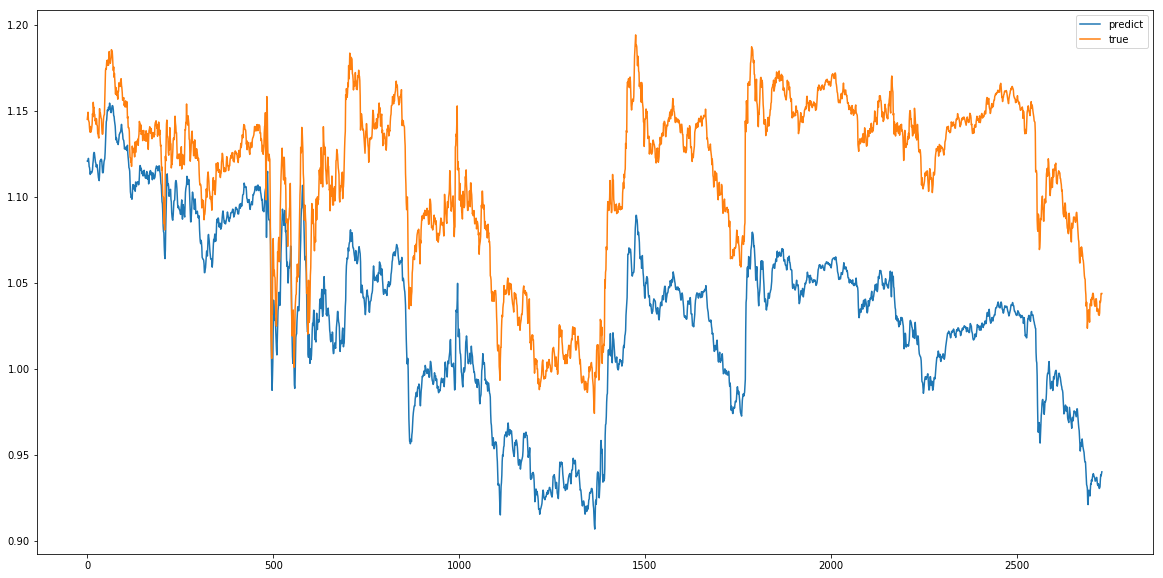

Test RMSE: 0.08921
Test MAE: 0.08322
Test MSE: 0.00796
Test RMSE: 442.33223
Test MAE: 412.62117


In [339]:
##1dcnn(5,3,1)
from matplotlib import pyplot
yhat = model.predict([X_test])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=target_test*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

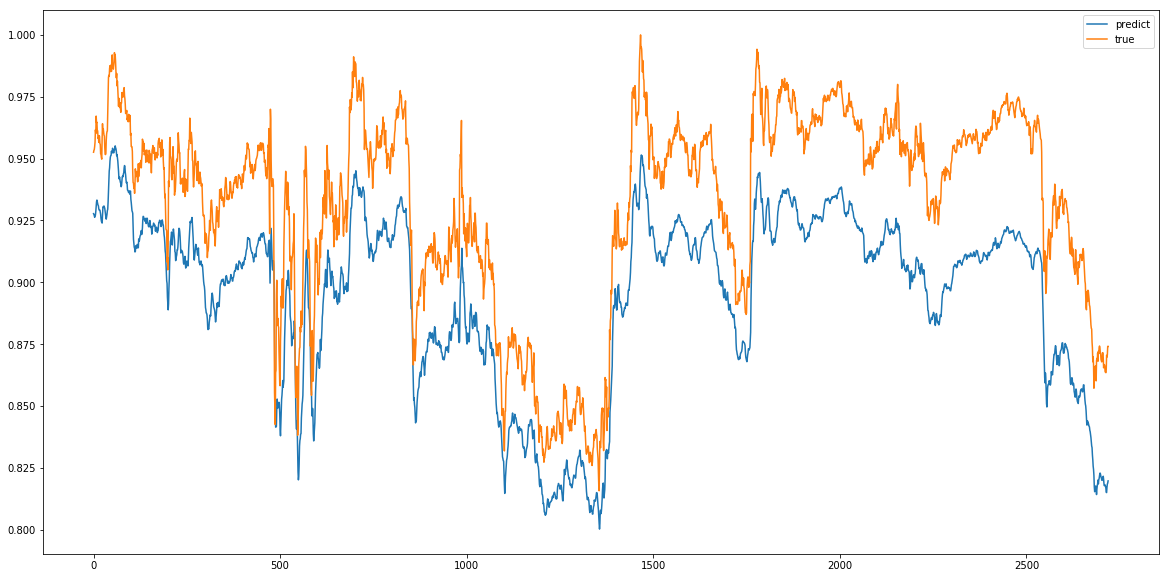

In [168]:
from matplotlib import pyplot
yhat = model.predict([testX])

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [44]:
from tensorflow.keras.models import *

In [45]:
first_input = Input(shape=(None,20,82))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True,recurrent_dropout=0.2))(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=7, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, 20, 82)]    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 20, 150)     139800    
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 20, 64)      9664      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 10, 64)      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 640)         0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           641       
Total params: 150,105
Trainable params: 150,105
Non-trainable params: 0
_______________________________________________________

In [46]:
checkpoint_path = "saved_weights/nas_lstmcnn_imv_128.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [51]:
history=model.fit(trainX, target_train, epochs=200, batch_size=128, validation_data=(valX, target_val),shuffle=False, verbose=1, callbacks=[cb])

Epoch 1/200
275/275 [==============================] - ETA: 0s - loss: 0.0229
Epoch 00001: val_loss did not improve from 0.00113
275/275 [==============================] - 11s 41ms/step - loss: 0.0229 - val_loss: 0.0492
Epoch 2/200
274/275 [============================>.] - ETA: 0s - loss: 0.0392
Epoch 00002: val_loss did not improve from 0.00113
275/275 [==============================] - 11s 42ms/step - loss: 0.0393 - val_loss: 0.0454
Epoch 3/200
275/275 [==============================] - ETA: 0s - loss: 0.0360
Epoch 00003: val_loss did not improve from 0.00113
275/275 [==============================] - 11s 41ms/step - loss: 0.0360 - val_loss: 0.0437
Epoch 4/200
275/275 [==============================] - ETA: 0s - loss: 0.0230
Epoch 00004: val_loss did not improve from 0.00113
275/275 [==============================] - 11s 41ms/step - loss: 0.0230 - val_loss: 0.0307
Epoch 5/200
275/275 [==============================] - ETA: 0s - loss: 0.0153
Epoch 00005: val_loss did not improve from

275/275 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00075: val_loss did not improve from 0.00113
275/275 [==============================] - 8s 30ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 76/200
275/275 [==============================] - ETA: 0s - loss: 0.0011
Epoch 00076: val_loss did not improve from 0.00113
275/275 [==============================] - 9s 31ms/step - loss: 0.0011 - val_loss: 0.0088
Epoch 77/200
275/275 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00077: val_loss did not improve from 0.00113
275/275 [==============================] - 8s 31ms/step - loss: 0.0013 - val_loss: 0.0092
Epoch 78/200
275/275 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00078: val_loss did not improve from 0.00113
275/275 [==============================] - 9s 31ms/step - loss: 0.0020 - val_loss: 0.0124
Epoch 79/200
275/275 [==============================] - ETA: 0s - loss: 0.0017
Epoch 00079: val_loss did not improve from 0.00113
275

Epoch 149/200
275/275 [==============================] - ETA: 0s - loss: 0.0012
Epoch 00149: val_loss did not improve from 0.00113
275/275 [==============================] - 8s 31ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 150/200
275/275 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00150: val_loss did not improve from 0.00113
275/275 [==============================] - 9s 31ms/step - loss: 0.0015 - val_loss: 0.0099
Epoch 151/200
275/275 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00151: val_loss did not improve from 0.00113
275/275 [==============================] - 8s 31ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 152/200
275/275 [==============================] - ETA: 0s - loss: 8.8930e-04
Epoch 00152: val_loss did not improve from 0.00113
275/275 [==============================] - 8s 31ms/step - loss: 8.8930e-04 - val_loss: 0.0038
Epoch 153/200
275/275 [==============================] - ETA: 0s - loss: 7.1499e-04
Epoch 00153: val_loss di

In [52]:
model.load_weights("saved_weights/nas_lstmcnn_imv_128.hdf5")

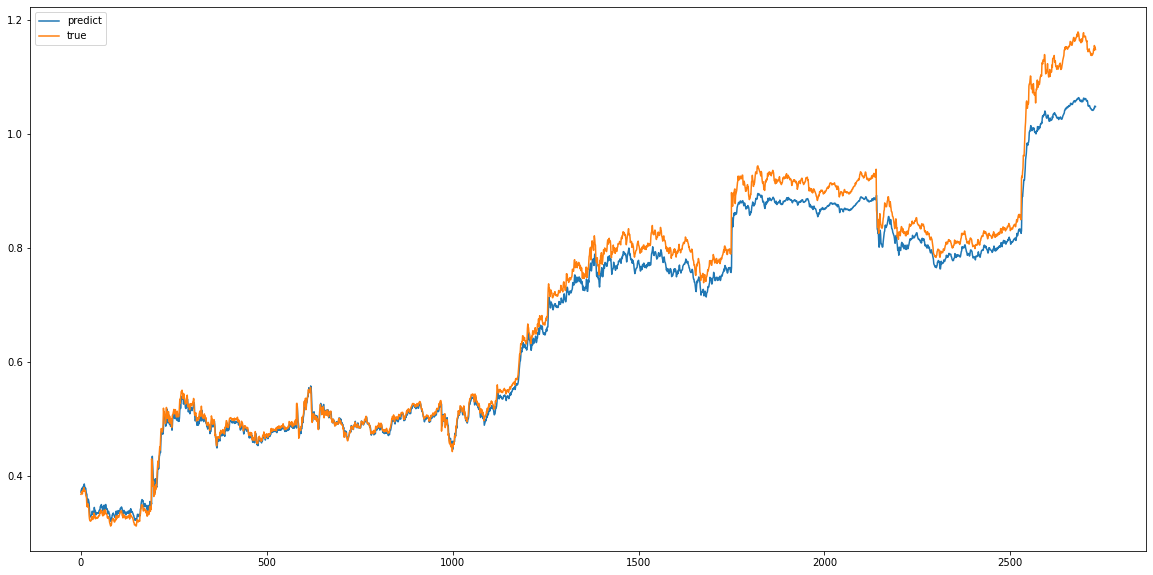

In [53]:
from matplotlib import pyplot
yhat = model.predict([valX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(target_val, label='true')
pyplot.legend()
pyplot.show()

In [55]:

from math import *
rmse = sqrt(mean_squared_error(target_val, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.03355


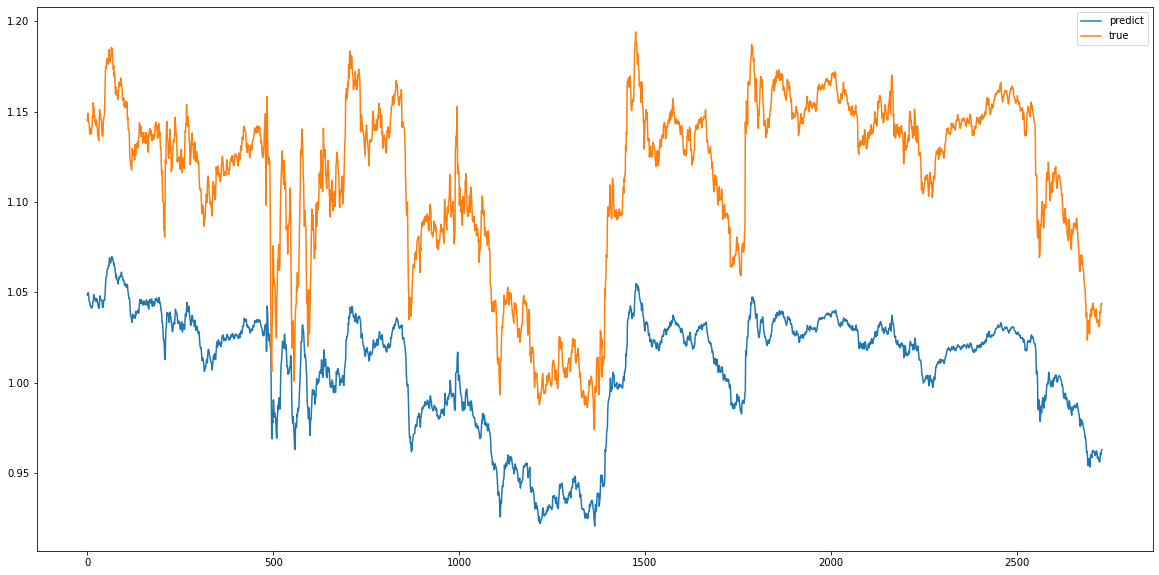

Test RMSE: 0.10611
Test MAE: 0.10432
Test MSE: 0.01126


In [57]:

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))


pyplot.plot(yhat, label='predict')
pyplot.plot(target_test, label='true')

pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(target_test, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(target_test, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(target_test, yhat)
print('Test MSE: %.5f' % mse)


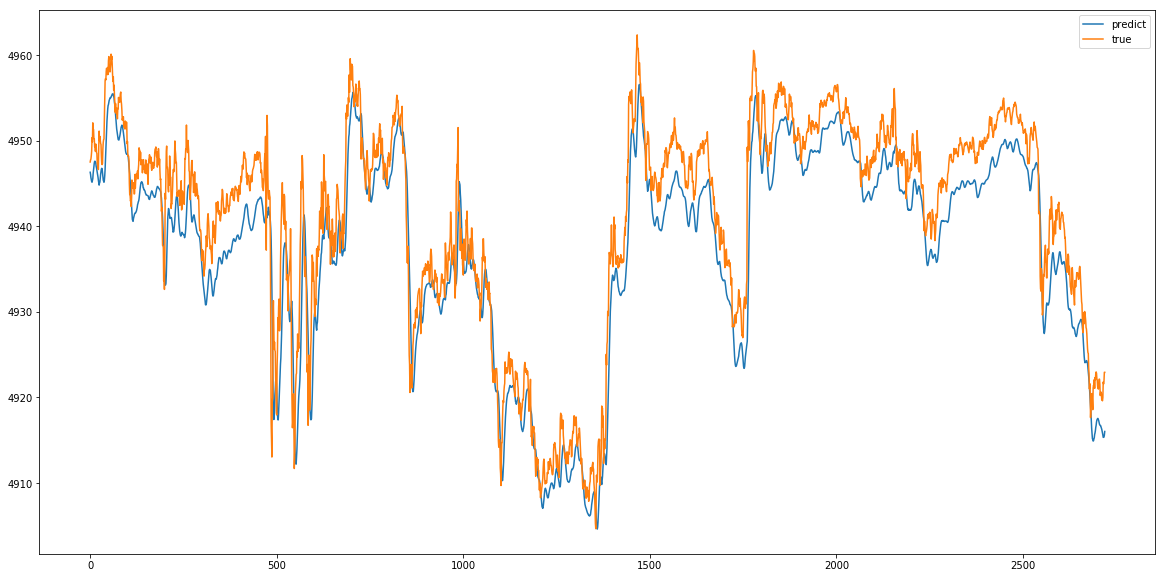

Test RMSE: 4.72999
Test MAE: 3.95179
Test MSE: 22.37284


In [208]:
from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')

pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)



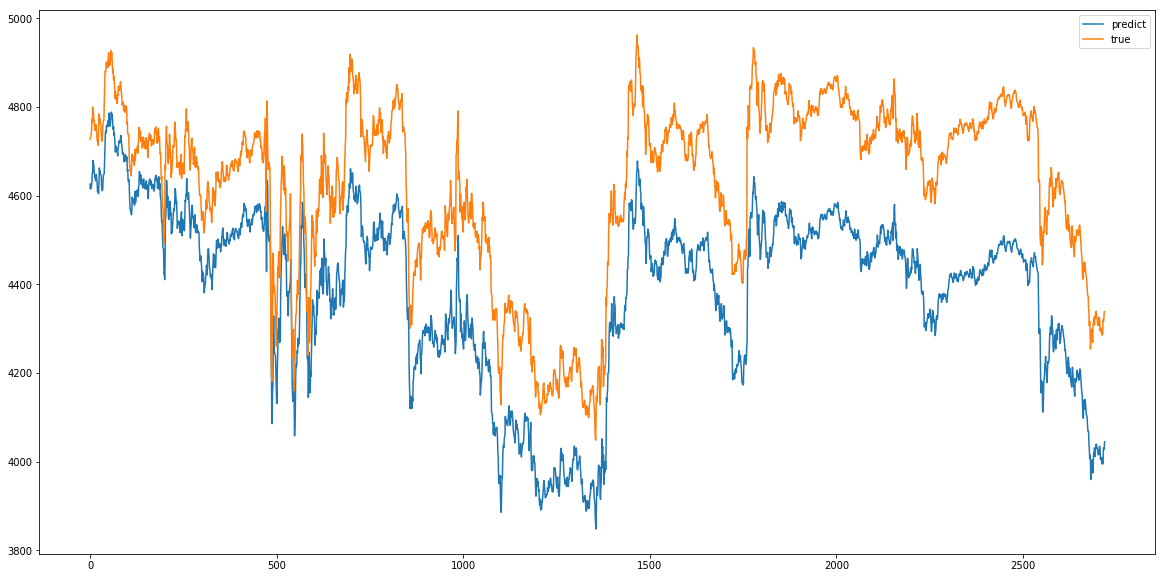

In [121]:

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='true')

pyplot.legend()
pyplot.show()

### attention cnn, cnn, rescnn 순서

In [45]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 2.78804


In [49]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 5.21353


In [35]:
from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.01849


In [86]:
from tensorflow.keras.models import Model


def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

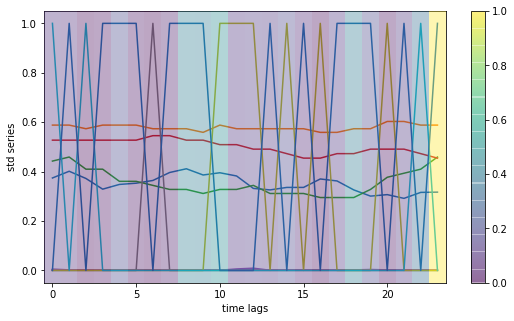

In [107]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

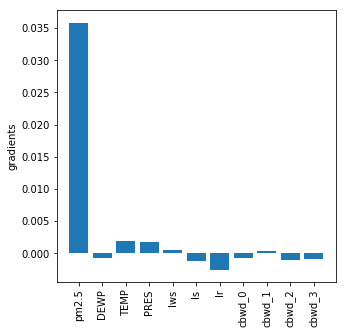

In [106]:
columns=data.columns[5:]

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)